In [1]:
## Setup

NOTE: All dependencies are within a conda environment to ensure reproducibility. To install all dependencies: pip install -r requirements.txt

In [2]:
import tensorflow.compat.v1 as tf
#Lets see if tensorflow finds the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# import tensorflow as tf

2023-04-24 18:53:44.824320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 18:53:44.863004: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Num GPUs Available:  1


2023-04-24 18:53:45.687503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-24 18:53:45.700771: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-24 18:53:45.700891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
# #Lets see if it works
tf.ones(1) + tf.ones(1)

2023-04-24 18:53:45.704311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 18:53:45.705130: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-24 18:53:45.705238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-24 18:53:45.705311: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative val

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.], dtype=float32)>

In [4]:
import numpy as np # for working with arrays and matrices
import pandas as pd # for data manipulation and analysis
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for data visualization
import time # for time-related functions
import random # for random number generation
import cv2 # for computer vision and image processing tasks
import datetime # for saving date and time information
import csv # for loading csv files


import h5py # for working with HDF5 (Hierarchical Data Format) files
import boto3 # for working with Amazon Web Services (AWS)
from pynwb import NWBHDF5IO # for working with Neurodata Without Border (NWB) files
import fsspec 
from fsspec.implementations.cached import CachingFileSystem # library used for working with various file systems in Python.
import requests 
import aiohttp # libraries which are used for making HTTP requests in Python.
import os # OS module provides various operating system-related functions to the code
import pickle
import re


# used for splitting data into training and testing sets in Python.
from sklearn.model_selection import train_test_split 
# for generating a confusion matrix
# from sklearn.metrics import confusion_matrix



# # Classes and functions from the Keras library which is used for building and training deep learning models in Python.
# from keras.models import load_model
# from keras.models import model_from_json
# from keras.utils import to_categorical
# from keras.models import Sequential
# from keras.layers import Dropout
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# These import the Adam optimizer class and various other classes from the TensorFlow Keras library 
# which is a high-level neural networks API used for building and training deep learning models in Python.
# from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import plot_model
# from tensorflow.keras.callbacks import EarlyStopping
import imgaug.augmenters as iaa

import importlib

# # Loading functions
from load_calcium_video import load_video_data
from pixel_values_normalization import normalize_video
from align_behavior_to_calcium import align_files
from class_balance import check_class_imbalance
from model_architecture import construct_model
from preprocessing_model import model_preprocessing
from run_model import model_execution
from save_model_info import save_training_info
# from set_s3_connection import generate_s3_url
from plots import plot_first_frames, plot_random_frames
from send_email_when_code_is_run import send_email
#from class_balance import check_distribution_among_datasets
from run_k_fold_model import run_k_fold


from urllib.parse import urlparse
from ann_visualizer.visualize import ann_viz
import sys
sys.path.append('/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3')
# from tensorflow.keras.applications.inception_v3 import preprocess_input
from nwb_data_generator import NWBDataGenerator

# sklearn
from sklearn.model_selection import KFold



In [5]:
# Reloading modules
# importlib.reload(check_class_imbalance)

In [6]:
### Installing resnet-18

In [7]:
# Goal: Code Clean-up, 20 or 40 epochs per fold, Convert all plotting with seaborn, store results, in CSV
comment = "k-fold-cross validation, one video, corridor location labels"
experiment_ID = '3.0'
data_file = 'Animal3learnday9'
experiment_name = str(data_file)+"_"+str(experiment_ID)
train_test_split_strategy = "k-fold"
name = 'BPNN_V3'
model_version = str(name)+'_1'

%store experiment_ID

Stored 'experiment_ID' (str)


In [8]:
# Define the name of the output directory
output_dir = "output"

# Check if the output directory already exists
if not os.path.exists(output_dir):
    # Create the output directory
    os.mkdir(output_dir)

    # Create the balance, accuracy, loss, and cm directories inside the output directory
    os.mkdir(os.path.join(output_dir, "balance"))
    os.mkdir(os.path.join(output_dir, "accuracy"))
    os.mkdir(os.path.join(output_dir, "loss"))
    os.mkdir(os.path.join(output_dir, "cm"))
    os.mkdir(os.path.join(output_dir, "architecture"))
    os.mkdir(os.path.join(output_dir, "pickles"))
else:
    print(f"The directory {output_dir} already exists.")

The directory output already exists.


### Loading Calcium Video

In [9]:
s3_calcium_url = 'https://s3.ki.se/dmc-striatum-arrowmaze/processed-data/miniscope-recordings/export-to-nwb/animal3learnday9/20211026_142935_animal3learnday9.nwb?AWSAccessKeyId=5AMYRX4EUZ0MV0276K24&Signature=ZouXPOQ%2BFhp6GVtkyHorR15Z9bA%3D&Expires=1682336796'
video_data = load_video_data(s3_calcium_url)

Execution time: 0 hours, 0 minutes, 3 seconds


### Loading Multiple Videos

In [10]:
# # load the CSV file with the FOV information
# fov_info = pd.read_csv('/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/aligned_videos_animal3.csv')

In [11]:
# session_video_data = {}
# s3_calcium_url_list = ['https://s3.ki.se/dmc-striatum-arrowmaze/processed-data/miniscope-recordings/export-to-nwb/animal3learnday11/20211028_181307_animal3learnday11.nwb?AWSAccessKeyId=5AMYRX4EUZ0MV0276K24&Signature=LEjcw1bFE3zkfFj8YL8UWgcCtJ8%3D&Expires=1681745157']
#                        # 'https://s3.ki.se/dmc-striatum-arrowmaze/processed-data/miniscope-recordings/export-to-nwb/animal3learnday10/20211027_165052_animal3learnday10.nwb?AWSAccessKeyId=5AMYRX4EUZ0MV0276K24&Signature=wvSHz9bYkQZ3k1RX%2BN4O9urXXRo%3D&Expires=1681742213']

# for s3_calcium_url in s3_calcium_url_list:
#     session_name = os.path.basename(os.path.dirname(urlparse(s3_calcium_url).path))
#     print(session_name)
#     video_data = load_video_data(s3_calcium_url)
#     # session_video_data[session_name] = video_data

### Preprocessing 

In [12]:
min_frame = np.min(video_data, axis=0)
video_data = video_data - min_frame

In [13]:
images = normalize_video(video_data)

Minimum pixel value: 0.000
Maximum pixel value: 1.0


In [14]:
# delete video_data 
del video_data

In [15]:
images[0].shape

(394, 415)

In [16]:
# Check if the video has been loaded correctly and normalized
images[:1]

array([[[0.02954545, 0.03181818, 0.04090909, ..., 0.02727273,
         0.01818182, 0.03181818],
        [0.04772727, 0.05      , 0.05454545, ..., 0.03181818,
         0.02954545, 0.03863636],
        [0.06590909, 0.03636364, 0.04772727, ..., 0.05      ,
         0.04318182, 0.04318182],
        ...,
        [0.10227273, 0.09090909, 0.08409091, ..., 0.09318182,
         0.05      , 0.06136364],
        [0.04545455, 0.10227273, 0.07954545, ..., 0.075     ,
         0.04545455, 0.05      ],
        [0.06818182, 0.07727273, 0.08181818, ..., 0.06363636,
         0.04318182, 0.04090909]]])

In [17]:
# Determine the size of the calcium video dataset
num_of_frames = images.shape[0]
img_height = images.shape[1]
img_width = images.shape[2]
print("The number of video frames is ", num_of_frames, " and the frame dimensions (height x width) are: ", img_height, "X", img_width)

The number of video frames is  24434  and the frame dimensions (height x width) are:  394 X 415


### Loading Bonsai and Behavior file

In [18]:
# Preparing bonsai data file.
# CSV with additional data from the behavior box, such as reward deliveries. Also includes information needed for synchronizing the calcium and behavioral recordings.
bonsai_data = pd.read_csv('/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-26T14_29_27.csv', header=None)

# Segmentation of each frame into one behavior class.
df_behavior = pd.read_hdf('/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211026_142935_animal3learnday9.h5', 'per_frame')

### Aligning Behavior with Calcium video

In [19]:
df_new_annotations, df_unique_states = align_files(bonsai_data, df_behavior)

/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/align_behavior_to_calcium.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_annotations.loc[:, 'state_id'] = df_new_annotations.loc[:, 'state_id'].replace(state_id_map)


In [20]:
df_new_annotations_unique = df_new_annotations.unique()
df_new_annotations_unique

array([0, 1, 2])

In [21]:
save_dir = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/output/balance"

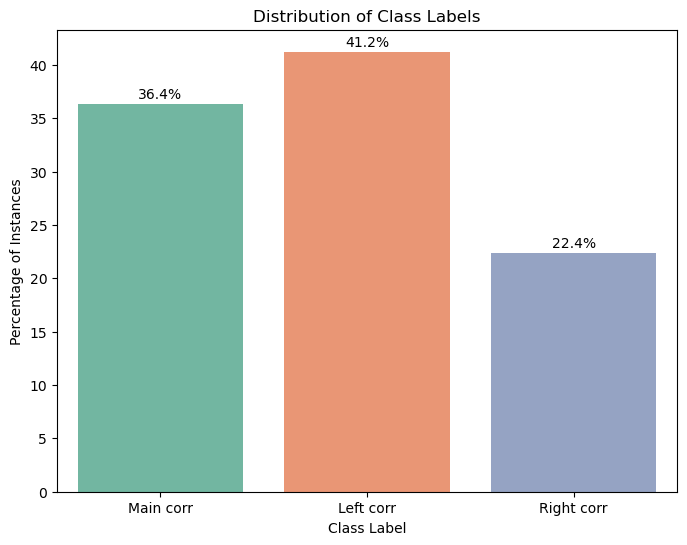

In [22]:
class_counts, total_counts = check_class_imbalance(df_new_annotations, experiment_ID, save_dir)

### Data Verification

In [23]:
# train_images, val_images, train_labels, val_labels, num_classes = model_preprocessing(train_images, val_images, train_labels, val_labels, df_new_annotations_unique)

### Preparing for K-fold

In [24]:
# Training Parameters
channel_dimension = 1
labels = df_new_annotations
epochs = 20
# batch_size = 8

In [25]:
input_shape = (img_height, img_width, channel_dimension)
input_shape

(394, 415, 1)

In [26]:
images, labels, num_classes = model_preprocessing(images, labels, df_new_annotations_unique)

### Starting K-fold

In [27]:
# start clock
start_time = time.time()


# set number of folds
num_folds = 5
shuffle = False

# Initialize lists to store the training and validation loss and accuracy values for each fold
train_loss_all = []
val_loss_all = []
train_acc_all = []
val_acc_all = []



train_loss_all, val_loss_all, train_acc_all, val_acc_all = run_k_fold(images, 
                                                                      labels, 
                                                                      num_folds, 
                                                                      shuffle, 
                                                                      input_shape, 
                                                                      num_classes, 
                                                                      name, 
                                                                      epochs,
                                                                      train_loss_all,
                                                                      val_loss_all, 
                                                                      train_acc_all,
                                                                      val_acc_all)



# end clock
end_time = time.time()
execution_time = end_time - start_time
hours, remainder = divmod(execution_time, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"Execution time: {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds")

Fold 1/5

Splitting data with NWBDataGenerator

Compiling model...

Training model. Go grab a coffee or take a walk.
Epoch 1/20


/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/run_k_fold_model.py:74: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,
2023-04-24 18:54:06.197941: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-04-24 18:54:07.145171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


610/610 [==============================] - 24s 35ms/step - loss: 1.0821 - accuracy: 0.3840 - val_loss: 1.0480 - val_accuracy: 0.2804
Epoch 2/20
610/610 [==============================] - 21s 35ms/step - loss: 0.9112 - accuracy: 0.5590 - val_loss: 1.7768 - val_accuracy: 0.3672
Epoch 3/20
610/610 [==============================] - 21s 35ms/step - loss: 0.6722 - accuracy: 0.7087 - val_loss: 1.6922 - val_accuracy: 0.3951
Epoch 4/20
610/610 [==============================] - 21s 35ms/step - loss: 0.5849 - accuracy: 0.7510 - val_loss: 1.9421 - val_accuracy: 0.3781
Epoch 4: early stopping

Evaluating model.


/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/run_k_fold_model.py:91: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_score = model.evaluate_generator(val_generator, verbose=0)


Validation accuracy: 0.3781

Execution time: 0 hours, 1 minutes, 29 seconds


In [ ]:
# model = construct_model(input_shape, num_classes, name)
# Plot the model's architecture to a file
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
%store train_loss_all
%store val_loss_all
%store train_acc_all
%store val_acc_all

In [ ]:
# Plot training and validation accuracy for each fold
plt.figure(figsize=(4, 3))
for i in range(num_folds):
    plt.plot(train_acc_all[i], label=f'Train Acc Fold {i+1}')
    plt.plot(val_acc_all[i], label=f'Val Acc Fold {i+1}')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Training-and-Validation-Accuracy.svg', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# Plot training and validation loss for each fold
for i in range(num_folds):
    plt.plot(train_loss_all[i], label=f'Train Loss Fold {i+1}')
    plt.plot(val_loss_all[i], label=f'Val Loss Fold {i+1}')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Training-and-Validation-Loss.svg', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# # Compute the average training and validation loss and accuracy values over all folds
# train_loss_avg = np.mean(train_loss_all, axis=0)
# val_loss_avg = np.mean(val_loss_all, axis=0)
# train_acc_avg = np.mean(train_acc_all, axis=0)
# val_acc_avg = np.mean(val_acc_all, axis=0)

# # Plot the average training and validation loss and accuracy values
# plt.plot(train_loss_avg, label='Training Loss')
# plt.plot(val_loss_avg, label='Validation Loss')
# plt.plot(train_acc_avg, label='Training Accuracy')
# plt.plot(val_acc_avg, label='Validation Accuracy')
# plt.legend()
# plt.show()

In [ ]:
from plots import plot_accuracy



In [ ]:
# Plot the training and validation accuracy for each fold
plt.figure(figsize=(8, 6))
for i, history in enumerate(all_histories):
    plt.plot(history.history['accuracy'], label=f'Train Fold {i+1}')
    plt.plot(history.history['val_accuracy'], label=f'Val Fold {i+1}')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# assume histories is a list of 5 History objects from k-fold validation
val_acc = [history.history['val_accuracy'] for history in all_histories]
mean_val_acc = np.mean(val_acc, axis=0)
std_val_acc = np.std(val_acc, axis=0)

plt.plot(mean_val_acc)
plt.fill_between(range(len(mean_val_acc)), mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, alpha=0.2)

plt.title('Mean Validation Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Mean Validation Accuracy')
plt.show()


In [ ]:
# SAVE ALL HISTORIES IN PICKLE AND LOAD FROM THE OTHER PIPELINE

In [ ]:
# mean_accuracy = np.mean(accuracy_score_list)
# std_accuracy = np.std(accuracy_score_list)

# print(f"Mean accuracy: {mean_accuracy:.4f}")
# print(f"Standard deviation of accuracy: {std_accuracy:.4f}")

In [ ]:
# assume histories is a list of 5 History objects from k-fold validation
for i in range(len(all_histories)):
    plt.plot(all_histories[i].history['val_accuracy'], label=f'Fold {i+1}')

plt.title('Validation Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Plot the training and validation accuracy for each fold

accuracy_dir = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/output/accuracy"
loss_dir = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/output/loss"

plt.figure(figsize=(8, 6))
for i, history in enumerate(all_histories):
    plot_accuracy(experiment_ID, history.history, accuracy_dir, i)
    plot_loss(experiment_ID, history.history, loss_dir, i)
    

#     plt.plot(history.history['accuracy'], label=f'Train Fold {i+1}')
#     plt.plot(history.history['val_accuracy'], label=f'Val Fold {i+1}')
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(loc='lower right')
# plt.show()

In [ ]:
# Save the history object to a pickle file
with open('All_histories.pkl', 'wb') as f:
    pickle.dump(all_histories.history, f)

In [ ]:
# from keras.models import load_model
# from keras.utils import plot_model

# # Load the model from the .h5 file
# model = load_model('k-fold-model.h5')




### Data Pre-processing

In [ ]:
# # Split the data into training and validation sets
split_index = int(0.2 * len(images))  # Index to split data

# images = np.concatenate([images, images, images], axis=-1)

val_images, train_images = images[:split_index], images[split_index:]
val_labels, train_labels = labels[:split_index], labels[split_index:]

In [ ]:
check_distribution_among_datasets(val_labels, experiment_ID, save_dir, dataset_type = 'Validation_set')
check_distribution_among_datasets(train_labels, experiment_ID, save_dir, dataset_type = 'Training_set')

In [ ]:
train_images, val_images, train_labels, val_labels, num_classes = model_preprocessing(train_images, val_images, train_labels, val_labels, df_new_annotations_unique)


In [ ]:
# Split the data into training and validation sets
# train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
vmin = 0
vmax = 0.20

In [ ]:
# # Plot the first 5 random images
plot_first_frames(train_images, train_labels, vmin, vmax)
plot_first_frames(val_images, val_labels, vmin, vmax)

In [ ]:
plot_random_frames(train_images, train_labels, vmin, vmax)
plot_random_frames(val_images, val_labels, vmin, vmax)

In [ ]:
input_shape = (img_height, img_width, channel_dimension)


In [ ]:
model = construct_model(input_shape, num_classes, name)


In [ ]:
validation_data=(val_images, val_labels)


In [ ]:
params = {
    'model': model,
    'tf': tf,
    'train_images': train_images,
    'train_labels': train_labels,
    'epochs': epochs,
    'batch_size': batch_size,
    'validation_data': validation_data,
    'val_images': validation_data[0],
    'val_labels': validation_data[1]
}

In [ ]:
save_dir = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/output/pickles"


In [ ]:
history = model_execution(params, save_dir, model_version)

In [ ]:
train_images, val_images, train_labels, val_labels, num_classes = model_preprocessing(train_images, val_images, train_labels, val_labels, df_new_annotations_unique)

In [ ]:
check_distribution_among_datasets(val_labels, experiment_ID, save_dir, dataset_type = 'Validation_set')
check_distribution_among_datasets(train_labels, experiment_ID, save_dir, dataset_type = 'Training_set')

#### Test set?

In [ ]:
# Split the data into training and validation sets
# train_images, val_images, train_labels, val_labels = train_test_split(images.reshape(num_of_frames, img_height, img_width, channel_dimension), labels, test_size=0.2, random_state=42)

In [ ]:
def train_and_evaluate_model(X_train, y_train, X_val, y_val, input_shape, num_classes, model_version):
    # Define the model
    model = construct_model(input_shape, num_classes, name=f'model_version_{model_version}')

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Define early stopping callback
    early_stop = EarlyStopping(patience=3, monitor='val_loss')

    # Train the model on this fold
    model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=10, callbacks=[early_stop])

    # Evaluate the model on the validation set for this fold
    score = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation accuracy: {score[1]:.4f}")

    # Save the model for this fold
    save_model(model, f'model_version_{model_version}.h5')

In [ ]:
def kfold_cross_validation(train_images, train_labels, num_classes, input_shape):
    # Define the number of folds
    num_folds = 5

    # Define the K-fold cross validator
    kf = KFold(n_splits=num_folds, shuffle=True)

    # Loop over the folds
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_images)):

        # Define the training and validation data for this fold
        X_train, y_train = train_images[train_idx], train_labels[train_idx]
        X_val, y_val = train_images[val_idx], train_labels[val_idx]

        # Train and evaluate the model
        train_and_evaluate_model(X_train, y_train, X_val, y_val, input_shape, num_classes, fold+1)

In [ ]:
kfold_cross_validation(train_images, train_labels, num_classes, input_shape)

In [ ]:
# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the function parameters
params = {
    'input_shape': input_shape,
    'num_classes': num_classes,
    'epochs': epochs,
    'batch_size': batch_size,
    'train_images': train_images,
    'train_labels': train_labels,
    'val_images': val_images,
    'val_labels': val_labels
}

# Call the function
train_and_evaluate_model(params)

#### Subtract the minimum frame from all other frames

In [ ]:
# # min_frame = np.min(images, axis=0)
# # background_removed_frames = []
# # for frame in images:
# #     background_removed_frames.append(frame - min_frame)
    
# # images = np.array(background_removed_frames)
# # min_frame = np.min(train_images, axis=0)
# # train_images = train_images - min_frame

# min_frame_train = np.min(train_images, axis=0)
# train_images = train_images - min_frame_train

# min_frame_val = np.min(val_images, axis=0)
# val_images = val_images - min_frame_val

In [ ]:
# str(labels[2400])

In [ ]:
# sys.path.append('/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V2/plots.py')

In [ ]:
# importlib.reload(plots.plot_first_frames)

In [ ]:
# plot_random_frames(train_images, train_labels, vmin, vmax)
# plot_random_frames(val_images, val_labels, vmin, vmax)

In [ ]:
# img_array = train_images[9000]

In [ ]:
# img = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)

In [ ]:
# # Overlay pixel values on top of the image
# for y in range(img_height):
#     for x in range(img_width):
#         value = img_array[y, x]
#         text = str(value)
#         font = cv2.FONT_HERSHEY_SIMPLEX
#         font_scale = 0.3
#         thickness = 1
#         color = (255, 255, 255)
#         position = (x, y)
#         cv2.putText(img, text, position, font, font_scale, color, thickness)


In [ ]:
# # Display the image
# cv2.imshow('image', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
# from sklearn.model_selection import KFold
# from keras.callbacks import EarlyStopping

# # Define the number of folds for cross-validation
# k = 5

# # Define the input shape and number of classes for the model
# input_shape = (img_height, img_width, channel_dimension)
# num_classes = 3

# # Define the early stopping callback
# early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# # Create the KFold object
# kf = KFold(n_splits=k)


# # Loop over the folds
# for fold, (train_idx, val_idx) in enumerate(kf.split(X)):

#     # Define the model
#     model = construct_model(input_shape, num_classes, name='model_fold{}'.format(fold+1))
    
#     # Compile the model
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
#     # Define the training and validation data for this fold
#     X_train, y_train = X[train_idx], y[train_idx]
#     X_val, y_val = X[val_idx], y[val_idx]
    
#     # Train the model on this fold
#     model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=10, callbacks=[early_stop])
    
#     # Evaluate the model on the validation set for this fold
#     score = model.evaluate(X_val, y_val, verbose=0)
#     print('Fold {} validation accuracy: {:.4f}'.format(fold+1, score[1]))
    
#     # Save the model for this fold
#     model.save('model_fold{}.h5'.format(fold+1))
    
# # Compute the average validation accuracy over all folds
# avg_val_acc = np.mean([score[1] for score in scores])
# print('Average validation accuracy: {:.4f}'.format(avg_val_acc))

#### Data Augmentation

In [ ]:
# # Perform data augmentation
# # Define the augmentation pipeline
# augmentation_pipeline = iaa.Sequential([
#     iaa.Fliplr(0.5), # flip horizontally with a probability of 0.5
#     iaa.Crop(percent=(0, 0.1)), # crop by up to 10% of the image width/height
#     iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))), # apply Gaussian blur with a probability of 0.5
#     # iaa.Affine(rotate=(-10, 10)) # rotate by up to 10 degrees
# ])

In [ ]:
# # Apply the augmentation pipeline to the training set
# augmented_train_images = []
# for image in train_images:
#     # Apply the same augmentation operation to both the image and its corresponding annotation
#     augmented_image = augmentation_pipeline(image=image)
#     augmented_train_images.append(augmented_image)


In [ ]:
# # Convert the augmented training set back to numpy arrays
# train_images = np.array(augmented_train_images)

In [ ]:
# plot_random_frames(train_images, labels)

### Build Model

In [ ]:
# Create the model by calling the function
model = construct_model(input_shape, num_classes, name)

In [ ]:
# plot model architecture
# plot_model(model, to_file='model_plot.png', show_shapes=False, show_layer_names=False)

In [ ]:
# import visualkeras
# from PIL import ImageFont
# visualkeras.layered_view(model, legend=True)
# # Define the directory name and the plot name
# dir_name = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/output/architecture"
# plot_name = f"{model_version}_architecture"
# ann_viz(model, view=True, filename=plot_name, title="CNN — "+str(name)+" — Simple Architecture")
# plot_path = os.path.join(dir_name, f"{plot_name}.png")
# plot = plt.gcf()
# plot.savefig(plot_path, dpi=300, bbox_inches="tight")

In [ ]:
# from ann_visualizer.visualize import ann_viz
# ann_viz(model, view=True, filename="cconstruct_model", title="CNN — Model 1 — Simple Architecture")

In [ ]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir='LR')

In [ ]:
# changes grayscale to rgb


In [ ]:
validation_data=(val_images, val_labels)

### Train Model

### K-fold cross validation

We have 24186 images of dimensions 349x374 and the number 1 demonstrates that images are grayscale.

In [ ]:
params = {
    'model': model,
    'tf': tf,
    'train_images': train_images,
    'train_labels': train_labels,
    'epochs': epochs,
    'batch_size': batch_size,
    'validation_data': validation_data,
    'val_images': validation_data[0],
    'val_labels': validation_data[1]
}

In [ ]:
save_dir = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/output/pickles"

In [ ]:
history = model_execution(params, save_dir, model_version)

In [ ]:
# # Call the send_email function after your model has finished training
# sender_email = 'guskikala@gmail.com'
# recipient_email = 'guskikala@gmail.com'
# subject = 'CNN Model Training Completed'
# message = 'Your CNN model training is complete!'

# send_email(sender_email, recipient_email, subject, message)

### Save results

In [ ]:
%store model
%store history
%store name
%store comment
%store experiment_ID
%store save_dir
%store model_version

In [ ]:
#save_training_info(model, history, video_name, comment, experiment_ID, save_dir, f1_score=f1_score)

High bias: If the training accuracy is low, it suggests that the model is underfitting the training data, i.e., it is not complex enough to capture the patterns in the data. In this case, you may need to increase the model's complexity by adding more layers or neurons, or by using a more complex architecture.

High variance: If the training accuracy is high but the validation accuracy is low, it suggests that the model is overfitting the training data, i.e., it is memorizing the training data instead of generalizing to new data. In this case, you may need to use regularization techniques like dropout or L2 regularization, or use early stopping to prevent the model from overfitting.

Good fit: If the training accuracy and validation accuracy are both high and close to each other, it suggests that the model is neither underfitting nor overfitting the data, i.e., it is generalizing well to new data.

Plateauing: If the validation accuracy is no longer increasing as the training set size or epochs increase, it suggests that the model has reached its capacity and adding more data or epochs is unlikely to improve its performance.

In general, a model accuracy curve can help you diagnose issues with your model and guide you in selecting appropriate strategies to improve its performance. It can also give you an idea of how much training data or how many epochs you need to achieve good performance.

In [ ]:
# def plot_confusion_matrix(model, images, labels, classes, title):
#     # Predict the class labels using the model
#     predicted_labels = np.argmax(model.predict(images), axis=1)

#     # Compute the confusion matrix using the predicted class labels and the true class labels
#     confusion = confusion_matrix(labels, predicted_labels)

#     # Plot the confusion matrix
#     fig, ax = plt.subplots(figsize=(10,10))
#     ax.imshow(confusion)
#     ax.set_xticks(np.arange(len(classes)))
#     ax.set_yticks(np.arange(len(classes)))
#     ax.set_xticklabels(classes)
#     ax.set_yticklabels(classes)
#     ax.set_xlabel('Predicted')
#     ax.set_ylabel('True')
#     ax.set_title(title)
#     plt.show()


In [ ]:

# # Plot the confusion matrix for the training set
# plot_confusion_matrix(model, train_images, train_labels, num_classes, 'Confusion Matrix for Training Set')

# # Plot the confusion matrix for the validation set
# plot_confusion_matrix(model, val_images, val_labels, num_classes, 'Confusion Matrix for Validation Set')

### Reflect on the results

1. Insufficient data? One calcium video of 24186 frames and with 349x374 dimensions.
2. Model architecture not appropriate. Try increasing the number of layers or filters, or adding more complex layers like BatchNormalization, Dropout, or Conv2DTranspose.
3. Incorrect data preprocessing
4. Incorrect hyperparameters
5. Class Imbalance (do oversampling, or undersampling)

### [Ignore for now]

In [ ]:
# from keras.layers import BatchNormalization
# from keras.preprocessing.image import ImageDataGenerator

# model = Sequential()

# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, channel_dimension)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())

# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(num_classes, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # reshape train_images to have 4 dimensions
# train_images = np.expand_dims(train_images, axis=-1)

# # Reshape train_images to have 4 dimensions
# #train_images = np.squeeze(train_images)
# # train_images = np.squeeze(train_images, axis=-1)
# # train_images = np.squeeze(train_images, axis=-1)
# # train_images = np.squeeze(train_images, axis=-1)
# # train_images = np.expand_dims(train_images, axis=-1)


# # Data augmentation
# train_datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, 
#                                    shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest')

# history = model.fit(train_datagen.flow(train_images, train_labels, batch_size=batch_size),
#                     epochs=epochs,
#                     steps_per_epoch=len(train_images) // batch_size,
#                     shuffle=True)

In [ ]:
# Reusable snippets

In [ ]:
# Load calcium video from local environment
# with h5py.File('path', 'r') as f:
#     video_data = np.array(f['analysis/recording_20211016_163921-PP-BP-MC/data'])

In [ ]:
# Loading locally
# with h5py.File('/Users/konstantinoskalaitzidis/Developer/dmc/thesis_data/20211016_163921_animal1learnday1.h5', 'r') as f:
#     print(list(f.keys()))
#     behavior_data = np.array(f['per_frame'])

In [ ]:
# # save the model architecture to a JSON file
# with open('model_architecture.json', 'w') as f:
#     f.write(model.to_json())

In [ ]:
# # load the model architecture from the JSON file
# with open('model_architecture.json', 'r') as f:
#     json_string = f.read()

# model_json = model_from_json(json_string)

# # print the loaded model summary
# model.summary()

In [ ]:
# mySession = readSessionServer.SessionIterator()
# sess = mySession.findSession()
# # for sess in mySession.findSessions():
# #     print(sess)
# if sess.hasBehavior() and sess.hasCalcium():
#     behavior = sess.getBehaviorSegmentation(align_with_calcium=True).reset_index()

## [Ignore for now] Define hyperparameters

In [ ]:
# IMG_SIZE = 224
# BATCH_SIZE = 64
# EPOCHS = 10

# MAX_SEQ_LENGTH = 20
# NUM_FEATURES = 2048

In [ ]:
# import sys
# sys.path.append("/Users/konstantinoskalaitzidis/Developer/dmc")
# from readSessionsServer import SessionIterator

#TODO: Script to retrieve videos from a list of calcium videos (of the same animal) from the db

## Dataset preparation and label annotation (feature engineering)

### [Ignore for now] Data availale for processing - overview

The following is not going to be used for now but will allow us to have an overview of all the videos I have available to train my CNN model. I expect to have all recordings sessions for each animal as input for the CNN which is going to be trained only based on recordings from the corresponding animal. The data will be split to train/test at some point...

In [ ]:
# train_df = pd.read_csv("train.csv")
# test_df = pd.read_csv("test.csv")

# print(f"Total videos for training: {len(train_df)}")
# print(f"Total videos for testing: {len(test_df)}")

# train_df.sample(10)

Extract frames from the calcium imaging video and save to directory. Each frame contains spatial information, and the sequence of those frames contains temporal information (the latter is not exploited for now). Maybe also ask for path input from the user to make it reproducible for others.

Helpful source: https://keras.io/examples/vision/video_classification/

The number of frames may differ from video to video.
The frame rate may also differ from video to video but it should be 20fps for all. 

The duration of each frame depends on the frame rate of the video. If a video has a frame rate of 25 fps, then each frame will have a duration of 1/25th of a second, or approximately 0.04 seconds. The calcium videos use 20fps, while the behavioral recordings are at 60fps. Alignment of these videos will follow shortly. 

### [Ignore for now] Fetch all calcium videos from the dmc database and align calcium videos with behavior annotations

In [ ]:
# mySession = readSessionServer.SessionIterator()
# for sess in mySession.findSessions():
#     print(sess)
    # if sess.hasBehavior() and sess.hasCalcium():
        # behavior = sess.getBehaviorSegmentation(align_with_calcium=True).reset_index()

### [Ignore for now] Open calcium video locally, create dir for saving frames and count number of frames with OpenCV

In [ ]:
# Open the HDF5 file
# with h5py.File('/Users/konstantinoskalaitzidis/Developer/dmc/thesis_data/20211016_163921_animal1learnday1.nwb', 'r') as f:
#     # Print the keys of the file
#     print(list(f.keys()))
#     # dataset = f['identifier'][()]
#     # print(dataset)

In [ ]:
# Directory where frames from video will be stored after extraction
# frames_dir = "path"

In [ ]:
# Open the video using OpenCV and count the number of frames
# cap = cv2.VideoCapture(raw_calcium_video_path)
# frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# cap.release()

# print(f"Number of frames in the video: {frame_count}")

In [ ]:
# video = 'path'

# cap = cv2.VideoCapture(video)
# frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# cap.release()

# print(f"Number of frames in the video: {frame_count}")

In [ ]:
# Open the video file
# cap = cv2.VideoCapture(video)

# # Get the frame rate of the video
# frame_rate = int(cap.get(cv2.CAP_PROP_FPS))

# # Release the video capture object
# cap.release()

# print(f"Frame rate of the video: {frame_rate}")

In [ ]:
# save each frame as one image

In [ ]:
# cap = cv2.VideoCapture(video)

# # Loop through the video frames and save each one as an image file
# frame_count = 0
# while(cap.isOpened()):
#     ret, frame = cap.read()
#     if ret == False:
#         break
#     # Save the frame as an image file
#     frame_file = os.path.join(frames_dir, "frame_" + str(frame_count) + ".jpg")
#     cv2.imwrite(frame_file, frame)
#     frame_count += 1

# # Close the video file
# cap.release()

In [ ]:
# # define paths
# video_path = '/Users/konstantinoskalaitzidis/Developer/dmc/thesis_data/20211016_163921_animal1learnday1.nwb'
# train_dir = '/Users/konstantinoskalaitzidis/Developer/dmc/thesis_data/train'
# test_dir = '/Users/konstantinoskalaitzidis/Developer/dmc/thesis_data/test'

# # define train-test split ratio
# train_test_ratio = 0.8

# # open video file
# cap = cv2.VideoCapture(video_path)

# # get video frame count
# frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# # create list of frame indices
# frame_indices = list(range(frame_count))

# # shuffle frame indices
# random.shuffle(frame_indices)

# # split frame indices into train and test sets
# train_frame_indices = frame_indices[:int(frame_count * train_test_ratio)]
# test_frame_indices = frame_indices[int(frame_count * train_test_ratio):]

# # iterate over frames and save to train or test directory
# for i in range(frame_count):
#     # read frame
#     ret, frame = cap.read()
#     if not ret:
#         break
    
#     # save frame to train or test directory
#     if i in train_frame_indices:
#         cv2.imwrite(os.path.join(train_dir, f'{i}.jpg'), frame)
#     else:
#         cv2.imwrite(os.path.join(test_dir, f'{i}.jpg'), frame)